# Lab 5: Regression and Dimensionality Reduction
* Student Name: Dylan Butler
* Student Number: 21218684

In [48]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Task 2: 
> Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with insurance.csv and draw conclusions from the results you observe in a markdown cell. Add a third regression algorithm of your choice. Describe how it compares to Random Forest and Linear regression in a markdown cell

## EDA

We start with a brief EDA to check for missing values and outliers.

In [153]:
df = pd.read_csv("./data/insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [154]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [155]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [156]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [157]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

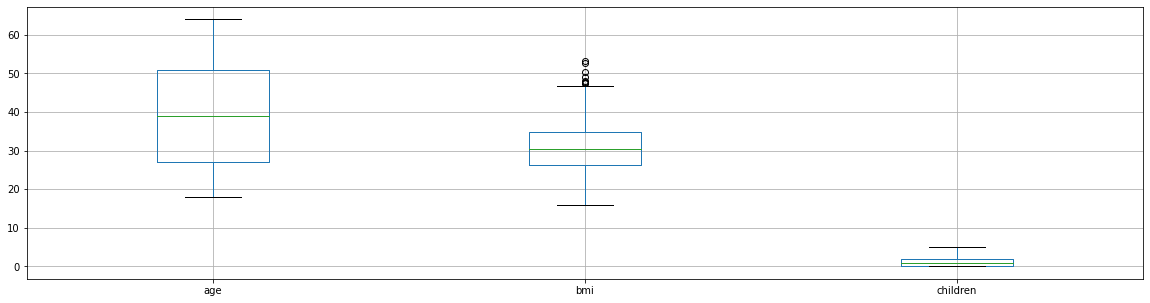

In [158]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

Nothing drastic in terms of outliers

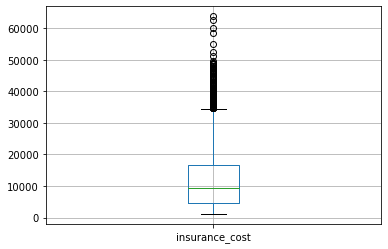

In [159]:
df.boxplot(column=['insurance_cost'])
plt.show()

`insurance_cost` has a large number of outliers. However, insurance depends on a number of factors so this holds as edge cases do exist

## Data Preparation

Next, we will replace the categorical column `gender`, `smoker`, `region` by multiple numerical columns. we will use `one-hot encoding` to do this. 

In [160]:
df = pd.get_dummies(df, columns=['gender', 'smoker', 'region'], 
                        drop_first=True)

Let's examine the transformed dataset.

In [161]:
df.head()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
0   18  33.770         1      1725.55230            1           0   
1   18  34.100         0      1137.01100            1           0   
2   18  26.315         0      2198.18985            0           0   
3   18  38.665         2      3393.35635            0           0   
4   18  35.625         0      2211.13075            0           0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 0                 1                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0

In [162]:
df.tail()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
1333   64  31.825         2     16069.08475            0           0   
1334   64  26.885         0     29330.98315            0           1   
1335   64  26.410         0     14394.55790            1           0   
1336   64  36.960         2     49577.66240            1           1   
1337   64  23.760         0     26926.51440            1           1   

      region_northwest  region_southeast  region_southwest  
1333                 0                 0                 0  
1334                 1                 0                 0  
1335                 0                 0                 0  
1336                 0                 1                 0  
1337                 0                 1                 0

Since there are no obvious outliers, we will apply `StandardScaler` to all predictor columns witha very simple (compared to example A) pre-rpocessing pipeline.

In [163]:
preprocess_pipeline = make_pipeline(StandardScaler())

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [164]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [165]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor())])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [166]:
N_FEATURES_OPTIONS = [2, 4, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
N_EST_OPTIONS = [10,20,30]
MAX_FTRS_OPTIONS = ["auto", "sqrt", "log2"]
BTSTRP_OPTIONS = [True, False]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__n_estimators': N_EST_OPTIONS,
        'regresson__max_features': MAX_FTRS_OPTIONS,
        'regresson__bootstrap': BTSTRP_OPTIONS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__n_estimators': N_EST_OPTIONS,
        'regresson__max_features': MAX_FTRS_OPTIONS,
        'regresson__bootstrap': BTSTRP_OPTIONS,
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.856:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__bootstrap': True, 'regresson__max_depth': 4, 'regresson__max_features': 'auto', 'regresson__n_estimators': 10}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

### Linear Regression Pipeline

In [167]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [168]:
N_FEATURES_OPTIONS = [2, 4, 6, 8]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.747:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


## Stochastic Gradient Descent Regression

In [169]:
from sklearn.linear_model import SGDRegressor

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', SGDRegressor(max_iter=1000))])

In [170]:
N_FEATURES_OPTIONS = [2, 4, 6, 8]
ALPHA_OPTIONS = 10.0 ** -np.arange(1, 7)
EPS_OPTIONS = [0.001, 0.01, 0.1, 1]
LEARN_RATE_OPTIONS = ['constant', 'optimal', 'invscaling', 'adaptive']
LOSS_OPTIONS = ['squared_loss', 'huber', 'epsilon_insensitive']
PEN_OPTIONS = ['l2', 'l1', 'elasticnet']


#no need to provide search array for alpha this is applied in lassocv 
# already
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__alpha': ALPHA_OPTIONS,
        'regresson__learning_rate' : LEARN_RATE_OPTIONS,
        'regresson__loss': LOSS_OPTIONS,
        'regresson__penalty': PEN_OPTIONS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__alpha': ALPHA_OPTIONS,
        'regresson__learning_rate' : LEARN_RATE_OPTIONS,
        'regresson__loss': LOSS_OPTIONS,
        'regresson__penalty': PEN_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SGD_best_params = search.best_params_
SGD_best_model = search.best_estimator_

Best CV score = 0.748:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__alpha': 0.01, 'regresson__learning_rate': 'constant', 'regresson__loss': 'squared_loss', 'regresson__penalty': 'l1'}


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [171]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [172]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SG_mse, SG_mae, SG_r2 = evaluate_model(X_test, y_test, SGD_best_model)

In [173]:
print(RF_mse, RF_mae, RF_r2)
print(LR_mse, LR_mae, LR_r2)
print(SG_mse, SG_mae, SG_r2)

17465962.018816717 2429.16024516951 0.8684343985719775
34538812.62854815 4151.303938760378 0.739829981813245
33398602.133965876 4100.0327116495155 0.7484188290415079


We will use a Pandas bar plots to compare the results. 

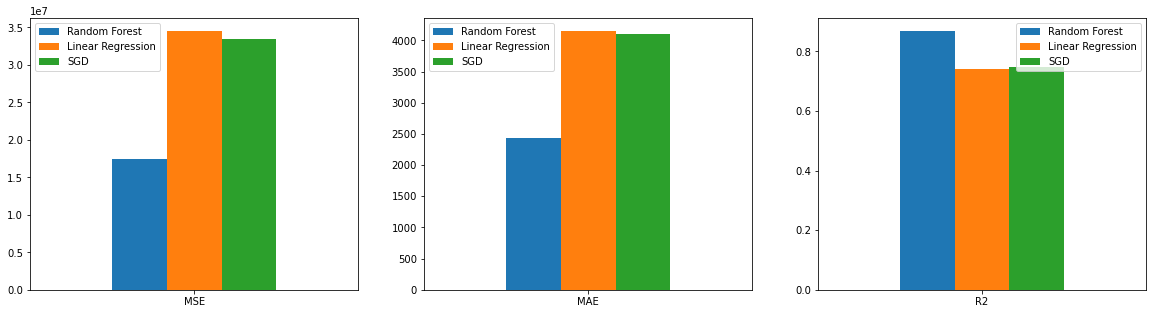

In [174]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SGD': SG_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SGD': SG_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SGD': SG_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

This tests confirms that Random Forest is the better regression model with lower MSE and MAE and higher R2.

### Task 2 reflection:

Stochastic Gradient Descent Regrssion was the third algorithm I decided to train. We can see that SGD is very similar to Linear Regression when it comes to scoring metrics. 
* Lin. Reg
    * CV Score: 74.7%
    * MSE: 34538812.62	
    * MAE: 4151.30	
    * R2: 0.739
* SGD
    * CV Score: 74.8%
    * MSE: 33398602.13
    * MAE: 4100.03	
    * R2: 0.748

However, it is nowhere near as good as random forest which outscores both lin reg and SGD. 

It is also interesting to note that the dimension reduction params are identical in the both lin. reg. and SGD
* Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6

Regardles of the fact SGD implements various loss functions and penalties to fit to the data it hasn't made much of a difference compared to Lin. Reg. 

## Task 3:
> Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 - Regression and Dimensionality Reduction.ipynb to the training pipelines for insurance.csv. Aim at dimensionality reduction techniques that are sufficiently different from the ones used in the example notebook. Draw conclusions from the results you observe in a markdown cell (max 250 words in a markdown cell).

### Observations on best dim-red. to select:
#### Missing Value Ratio
* no missing values in the dataset so we can count out Missing Value Ratio

#### Low Variance Filter
* most of the variables are categorical (one-hot encoded) this might not give us a lot of insight

<a id='correlation_cell'></a>
#### High Correlation filter
* this could be an interesting one to apply

In [175]:
df.drop(['insurance_cost'], axis=1).corr()

age       bmi  children  gender_male  smoker_yes  \
age               1.000000  0.109272  0.042469    -0.020856   -0.025019   
bmi               0.109272  1.000000  0.012759     0.046371    0.003750   
children          0.042469  0.012759  1.000000     0.017163    0.007673   
gender_male      -0.020856  0.046371  0.017163     1.000000    0.076185   
smoker_yes       -0.025019  0.003750  0.007673     0.076185    1.000000   
region_northwest -0.000407 -0.135996  0.024806    -0.011156   -0.036945   
region_southeast -0.011642  0.270025 -0.023066     0.017117    0.068498   
region_southwest  0.010016 -0.006205  0.021914    -0.004184   -0.036945   

                  region_northwest  region_southeast  region_southwest  
age                      -0.000407         -0.011642          0.010016  
bmi                      -0.135996          0.270025         -0.006205  
children                  0.024806         -0.023066          0.021914  
gender_male              -0.011156          0.017117         -0.004184  
smoker_yes               -0.036945          0.068498         -0.036945  
region_northwest          1.000000         -0.346265         -0.320829  
region_southeast         -0.346265          1.000000         -0.346265  
region_southwest         -0.320829         -0.346265          1.000000

Looking at the above table there is nothing that stands out as being highly correlated

#### Random Forest

In [176]:
fs_model_RF = RandomForestRegressor(random_state=1, max_depth=10)
fs_model_RF.fit(df.drop(['insurance_cost'],axis=1),df.insurance_cost)

RandomForestRegressor(max_depth=10, random_state=1)

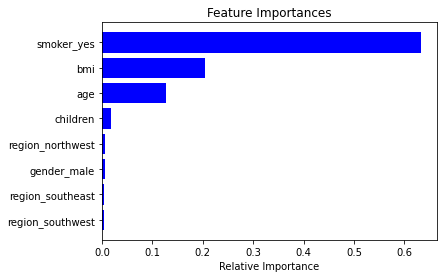

In [177]:
features = df.drop(['insurance_cost'], axis=1).columns
importances = fs_model_RF.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Straight away we can see that the three most influential features are `smoker_yes`, `bmi`, `age`, `children`.

Let's train a model using these 4 features only to see if we can improve our three models above

#### NOTE: no need to apply best feature selection here - we already have them

In [191]:
X_train_ = np.concatenate( (X_train[:, :2], X_train[:, 4:5]),axis=1)
X_test_ = np.concatenate( (X_test[:, :2], X_test[:, 4:5]),axis=1)

In [195]:
X_train_

array([[23.  , 26.51,  0.  ],
       [54.  , 32.3 ,  0.  ],
       [30.  , 31.4 ,  0.  ],
       ...,
       [41.  , 40.26,  0.  ],
       [38.  , 38.39,  1.  ],
       [31.  , 29.1 ,  0.  ]])

### Random Forest Regressor

In [196]:
# Random Forest - no need to apply the best features here 
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('regresson', RandomForestRegressor())])

param_grid = [
    {
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__n_estimators': N_EST_OPTIONS,
        'regresson__max_features': MAX_FTRS_OPTIONS,
        'regresson__bootstrap': BTSTRP_OPTIONS,
    } 
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train_, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.853:
Best parameters:  {'regresson__bootstrap': True, 'regresson__max_depth': 4, 'regresson__max_features': 'auto', 'regresson__n_estimators': 30}


### Linear Regression

In [197]:
# Random Forest - no need to apply the best features here 
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('regresson', LinearRegression())])

param_grid = [
    {
        'regresson__normalize': NORMALIZE_OPTIONS
    }
]


search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train_, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.745:
Best parameters:  {'regresson__normalize': False}


### SGD Regression

In [198]:
# Random Forest - no need to apply the best features here 
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('regresson', SGDRegressor(max_iter=1000))])

#no need to provide search array for alpha this is applied in lassocv 
# already
param_grid = [
    {
        'regresson__alpha': ALPHA_OPTIONS,
        'regresson__epsilon': EPS_OPTIONS,
        'regresson__learning_rate' : LEARN_RATE_OPTIONS,
        'regresson__loss': LOSS_OPTIONS,
        'regresson__penalty': PEN_OPTIONS,
    }
]


search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train_, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SGD_best_params = search.best_params_
SGD_best_model = search.best_estimator_

Best CV score = 0.747:
Best parameters:  {'regresson__alpha': 1e-05, 'regresson__epsilon': 0.1, 'regresson__learning_rate': 'constant', 'regresson__loss': 'squared_loss', 'regresson__penalty': 'l1'}


### Observe the results

In [201]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test_, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test_, y_test, LR_best_model)
SG_mse, SG_mae, SG_r2 = evaluate_model(X_test_, y_test, SGD_best_model)

df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SGD': SG_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SGD': SG_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SGD': SG_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

In [202]:
print(RF_mse, RF_mae, RF_r2)
print(LR_mse, LR_mae, LR_r2)
print(SG_mse, SG_mae, SG_r2)

17951607.640453637 2450.085794810615 0.8647761827678487
34662058.746132016 4203.42783122424 0.7389016075521466
35942392.55650545 4321.21323348767 0.7292572554340706


## Let's add in a third Dimension Reduction Technique

### Random Forest Regressor

In [147]:
from sklearn.decomposition import FastICA

In [148]:
# Random Forest - no need to apply the best features here 
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor())])

param_grid = [
    {
        'reduce_dim': [FastICA(random_state=12)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__n_estimators': N_EST_OPTIONS,
        'regresson__max_features': MAX_FTRS_OPTIONS,
        'regresson__bootstrap': BTSTRP_OPTIONS,
    } 
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.829:
Best parameters:  {'reduce_dim': FastICA(n_components=8, random_state=12), 'reduce_dim__n_components': 8, 'regresson__bootstrap': True, 'regresson__max_depth': 6, 'regresson__max_features': 'auto', 'regresson__n_estimators': 30}


### Linear Regression

In [149]:
# Random Forest - no need to apply the best features here 
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

param_grid = [
    {
        'reduce_dim': [FastICA(random_state=12)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }
]


search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.749:
Best parameters:  {'reduce_dim': FastICA(n_components=8, random_state=12), 'reduce_dim__n_components': 8, 'regresson__normalize': False}


### SGD

In [150]:
# Random Forest - no need to apply the best features here 
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('regresson', SGDRegressor(max_iter=1000))])

#no need to provide search array for alpha this is applied in lassocv 
# already
param_grid = [
    {
        'reduce_dim': [FastICA(random_state=12)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__alpha': ALPHA_OPTIONS,
        'regresson__epsilon': EPS_OPTIONS,
        'regresson__learning_rate' : LEARN_RATE_OPTIONS,
        'regresson__loss': LOSS_OPTIONS,
        'regresson__penalty': PEN_OPTIONS,
    }
]


search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SGD_best_params = search.best_params_
SGD_best_model = search.best_estimator_

Best CV score = 0.745:
Best parameters:  {'reduce_dim': FastICA(n_components=8, random_state=12), 'reduce_dim__n_components': 8, 'regresson__alpha': 1e-06, 'regresson__epsilon': 0.01, 'regresson__learning_rate': 'adaptive', 'regresson__loss': 'squared_loss', 'regresson__penalty': 'l1'}


C:\Users\dbc14\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### Observe results

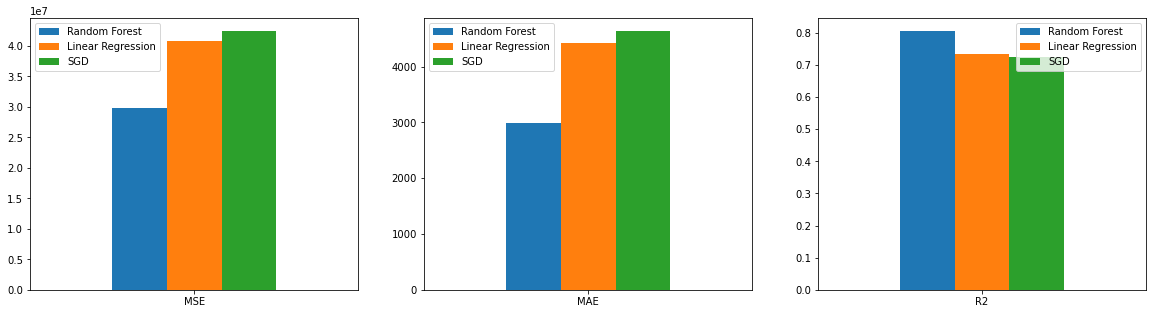

In [151]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SG_mse, SG_mae, SG_r2 = evaluate_model(X_test, y_test, SGD_best_model)

df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SGD': SG_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SGD': SG_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SGD': SG_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

In [152]:
print(RF_mse, RF_mae, RF_r2)
print(LR_mse, LR_mae, LR_r2)
print(SG_mse, SG_mae, SG_r2)

29834702.180756338 2982.710141376679 0.806203068133917
40812782.94079992 4416.00138899504 0.734892875185291
42451316.5451456 4638.915291155869 0.724249471294151


## Overview of Results

| **model**           | **dimension reduction technique** | **Best CV Score** | **MSE**           | **MAE**       | **R2**      |
|---------------------|-----------------------------------|-------------------|-------------------|---------------|-------------|
| **Random Forest** | **RFE SVR**                     | **85.6%**      | **17465962.01** | **2429.16** | **0.868** |
| Lin. Reg            | RFE Lin. Reg.                     | 74.7%             | 34538812.62       | 4151.30       | 0.739       |
| SGD                 | RFE Lin. Reg.                     | 74.8%             | 33398602.13       | 4100.03       | 0.748       |
| Random Forest       | Random Forest Feature Importance  | 85.3%             | 17951607.64       | 2450.08       | 0.864       |
| Lin. Reg.           | Random Forest Feature Importance  | 74.5%             | 34662058.74       | 4203.42       | 0.738       |
| SGD                 | Random Forest Feature Importance  | 74.7%             | 35942392.55       | 4321.21       | 0.729       |
| Random Forest       | ICA                               | 82.9%             | 29834702.18       | 2982.71       | 0.806       |
| Lin. Reg.           | ICA                               | 74.9%             | 40812782.94       | 4416.00       | 0.734       |
| SGD                 | ICA                               | 74.5%             | 42451316.54       | 4638.91       | 0.724       |

### Task 3: Reflection
The two additional Dim. Red. techniques I used where; Random Forest Feature Importance and Independent Component Analysis. 
#### Random Forest  feature importance:
We can see from the results table that the feature importance experiment was extremely successful. The scoring metrics for the model using the 3 important features; (1) Age, (2) BMI and (3) smoker_yes are slightly lower but extremely similar to the models trained with all of the data points. 

#### ICA: 
With independent component analysis, focuses completely on independence, compared to PCA which focuses on maximising the variance on the data points. However, in this case ICA actually used 8 components which is the same as the original number of features. This is probably due to the fact that there are [no correlations](#correlation_cell) that stand out in the data. Observing the results we can see that random forest's and SGD's CV score droped but Lin. Reg increased slightly. Regardless of the higher CV score, if we observe the scoring metrics on the test set it actually did not improve at all.